# Visualize and estimate extra distance of transatlantic flights compared to orthodromic distance

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import contextily as cx
from traffic.data import airports
from trajtools import (
    NM_TO_M,
    traffic_from_opensky,
    traffic_from_parquet,
    traffic_to_gdf,
    to_line_gdf,
    flight_to_ortho,
    great_circle_trajectory,
    great_circle_distance,
    ortho_distance,
    cum_distance,
)

In [3]:
adep = "LFPG"
ades = "KJFK"
airports[adep].latlon

(49.012798, 2.55)

#### Load ADS-B data from the OpenSky Network (to be used only once, then use directly parquet file)

In [4]:
recorded_traffic = traffic_from_opensky(
    "2022-12-01 00:00:01",
    "2022-12-31 23:59:59",
    departure_airport=adep,
    arrival_airport=ades,
)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 743/744  [ 1:10:57 < 0:00:06 , 0 it/s ]
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 743/744  [ 1:10:57 < 0:00:06 , 0 it/s ]

In [5]:
recorded_traffic.to_parquet(adep + "_" + ades + ".parquet")

#### Load ADS-b data from local parquet file

In [4]:
t = traffic_from_parquet(adep + "_" + ades + ".parquet")

#### Build great circle data (traj and distance)

In [5]:
ortho = great_circle_trajectory(
    airports[adep].latlon[0],
    airports[adep].latlon[1],
    airports[ades].latlon[0],
    airports[ades].latlon[1],
)
ortho_dist = great_circle_distance(
    airports[adep].latlon[0],
    airports[adep].latlon[1],
    airports[ades].latlon[0],
    airports[ades].latlon[1],
)
print(ortho_dist)

5849371.719672996


#### Build ADS-B flights

In [6]:
t2 = (
    t.iterate_lazy(iterate_kw=dict(by="8H")).assign_id().eval()
)  # ADS-B signal lost over ocean
t2

,count
flight_id,
DAL265_231,16487
DAL263_230,16176
DAL263_226,16074
DAL265_238,15990
AFR008_021,15982
AFR010_136,15968
AFR010_111,15953
AFR006_058,15720
DAL265_232,15676


In [7]:
def compare_distances(num1, num2):
    diff = abs(num1 - num2)
    avg = (num1 + num2) / 2
    return (lambda x, y: x / y <= 0.05)(diff, avg)

#### Plot all trajs with orthodromic interpolation if ADS-B positions missing

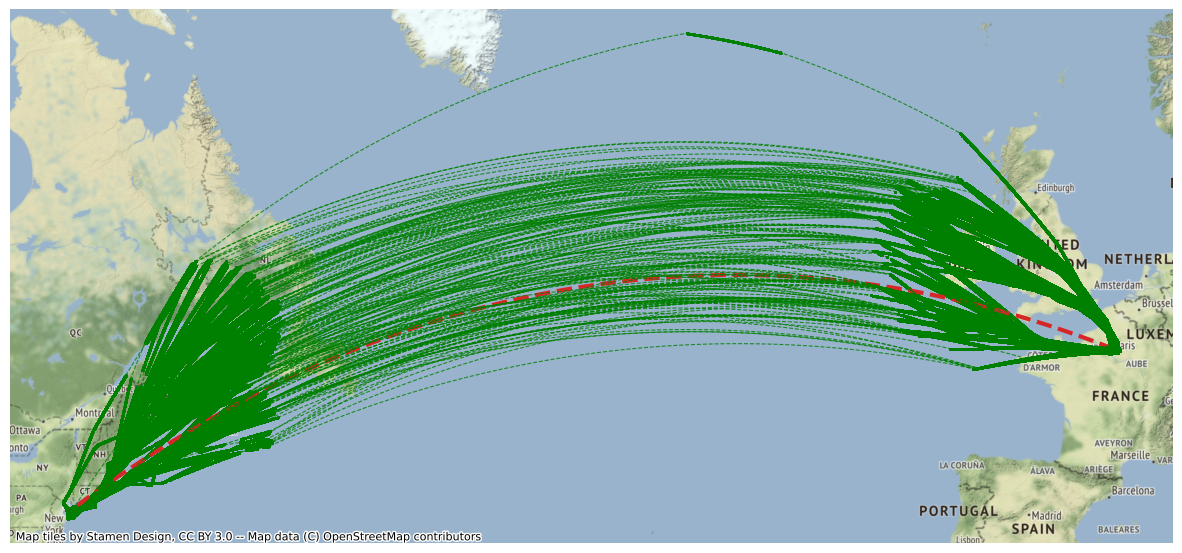

In [8]:
distances = {}
f, ax = plt.subplots(figsize=(15, 9))
to_line_gdf(ortho).to_crs("EPSG:3857").plot(
    ax=ax,
    linewidth=3.0,
    color="tab:red",
    linestyle="dashed",
)
for fid in t2.flight_ids:
    flight = t2[fid]
    if compare_distances(ortho_distance(flight), ortho_dist):  # less than 5% of diff
        t_r = flight.resample(rule="30s", projection="lcc")
        cumul_dist = cum_distance(flight)
        if cumul_dist >= ortho_dist:  # always true if real flight
            distances[flight.flight_id] = cumul_dist
            # Plot as points real positions received
            traffic_to_gdf(flight).to_crs("EPSG:3857").plot(
                ax=ax,
                markersize=1.0,
                color="green",
                alpha=0.8,
            )
            # Plot as dashed line interpolated traj
            to_line_gdf(traffic_to_gdf(t_r)).to_crs("EPSG:3857").plot(
                ax=ax, linewidth=0.8, color="green", linestyle="dashed", alpha=0.8
            )
cx.add_basemap(ax, source=cx.providers.Stamen.Terrain)
ax.axis("off")
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.savefig("all_flights.png", dpi=300, bbox_inches="tight", pad_inches=0)

#### Plot a specific flight (AFR006)

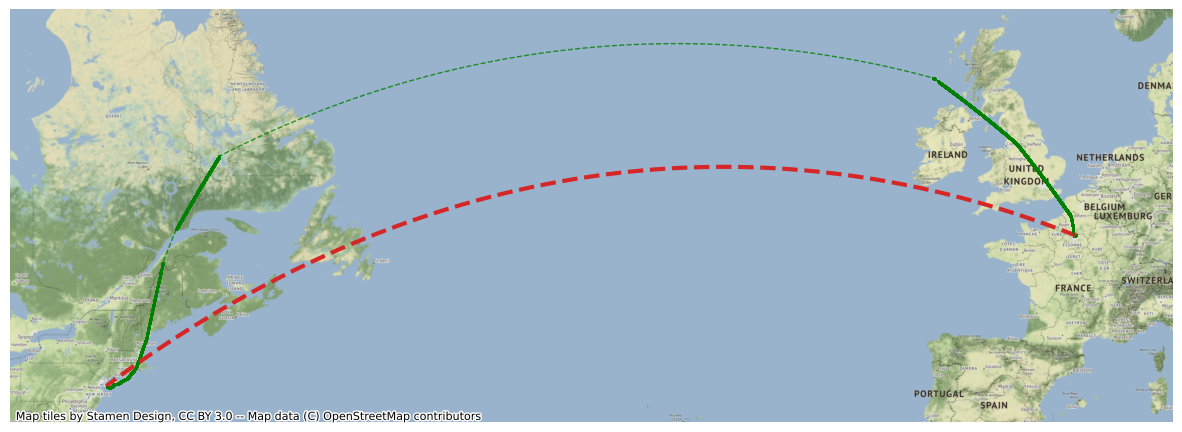

In [11]:
f, ax = plt.subplots(figsize=(15, 9))
to_line_gdf(ortho).to_crs("EPSG:3857").plot(
    ax=ax,
    linewidth=3.0,
    color="tab:red",
    linestyle="dashed",
)

flight = t2["AFR006_045"]
t_r = flight.resample(rule="30s", projection="lcc")

traffic_to_gdf(flight).to_crs("EPSG:3857").plot(
    ax=ax,
    markersize=1.0,
    color="green",
)

gdf_3857 = to_line_gdf(traffic_to_gdf(t_r)).to_crs("EPSG:3857")
gdf_3857.plot(ax=ax, linewidth=1.0, color="green", linestyle="dashed", alpha=0.8)
xmin, ymin, xmax, ymax = gdf_3857.total_bounds
marge_pct = 0.1
dx = (xmax - xmin) * marge_pct
dy = (ymax - ymin) * marge_pct
xlim = (xmin - dx, xmax + dx)
ylim = (ymin - dy, ymax + dy)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
cx.add_basemap(ax, source=cx.providers.Stamen.Terrain)  # TonerLite)
ax.axis("off")
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.savefig("AFR006.png", dpi=300, bbox_inches="tight", pad_inches=0)

#### Plot distribution of distances

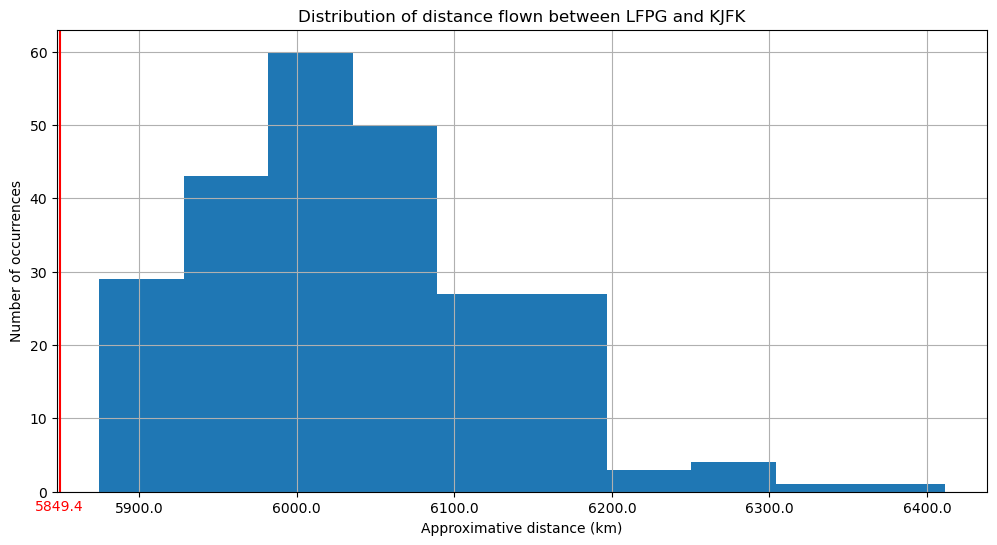

In [12]:
valeurs = list(distances.values())
valeurs_divisees = [v / 1000 for v in valeurs]
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(valeurs_divisees, bins=10)
ax.axvline(x=ortho_dist / 1000, color="r")
ax.set_xlabel("Approximative distance (km)")
ax.set_ylabel("Number of occurrences")
ax.set_title("Distribution of distance flown between LFPG and KJFK")
ax.set_xticklabels([str(tick) for tick in ax.get_xticks()])
ax.text(ortho_dist / 1000, -2.5, f"{ortho_dist / 1000:.1f}", color="r", ha="center")
plt.grid()
plt.savefig("distrib.png", dpi=300, bbox_inches="tight")
plt.show()